In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

!pip install livelossplot

/kaggle/input/2021-ai-w7-p2/sample_submission.csv
/kaggle/input/2021-ai-w7-p2/x_test.csv
/kaggle/input/2021-ai-w7-p2/y_train.csv
/kaggle/input/2021-ai-w7-p2/x_train.csv


In [2]:
import random
import torch

device='cuda' if torch.cuda.is_available() else 'cpu'

random.seed(777)
torch.manual_seed(777)
if device=='cuda':
    torch.cuda.manual_seed_all(777)

> 해당 데이터 셋은 제주시/서귀포시의 읍면동의 기온, 강수량, 풍속, 거주인구, 유동인구, 교통량...etc 측정하여 만들어진 데이터 셋입니다.
>
> [JejuDataHub](https://www.jejudatahub.net/)에서 제공하며, 원본 데이터는 해당 [링크](https://www.jejudatahub.net/data/view/data/753)에서 확인 할 수 있습니다.

### 한글이 포함된 csv 파일 로드 이슈

> 한글이 포함된 csv를 Pandas의 read_csv를 이용하여 불러올 경우, 다음과 같은 에러가 발생합니다.
> 
> `
> UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc0 in position 0: invalid start byte
> `
> 
> pandas.read_csv는 기본적으로 utf-8으로 encoding된 파일을 파싱하기 때문입니다.
> 
> 하지만 제공되는 데이터는 window 환경에서의 한글용 encoding, CP949을 이용하여 작성되었기 때문에 아래와 같은 방법으로 csv를 불러오시면 한글이 포함된 csv를 읽어 올 수 있습니다.
> 
> `
> db = pd.DataFrame(pd.read_csv(csv_path,engine='python',encoding='CP949'))
> `



In [3]:
from tabulate import tabulate

db=dict()
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        db[filename.split('.')[0]] = pd.DataFrame(pd.read_csv(os.path.join(dirname, filename),engine='python',encoding='CP949'))
        print(f'\n\n{filename.split(".")[0]}: {db[filename.split(".")[0]].shape}')
        print(tabulate(db[filename.split('.')[0]].head(5), headers='keys', tablefmt='psql'))



sample_submission: (10583, 2)
+----+------+-----------+
|    |   id |   predict |
|----+------+-----------|
|  0 |    0 |         0 |
|  1 |    1 |         0 |
|  2 |    2 |         0 |
|  3 |    3 |         0 |
|  4 |    4 |         0 |
+----+------+-----------+


x_test: (10583, 14)
+----+----------+------------+------------+------------+------------+---------------+-------------+------------------+-------------+------------+-------------+------+------+------+
|    |   시도명 |   읍면동명 |   거주인구 |   근무인구 |   방문인구 |   총 유동인구 |   평균 속도 |   평균 소요 시간 |   평균 기온 |   일강수량 |   평균 풍속 |   월 |   일 |   년 |
|----+----------+------------+------------+------------+------------+---------------+-------------+------------------+-------------+------------+-------------+------+------+------|
|  0 |        0 |         28 |    45737.8 |    8703.03 |      91775 |        146216 |      57.286 |           35     |       6.5   |          0 |         2.9 |    1 |   12 | 2020 |
|  1 |        1 |         21 |   2892

In [4]:
db['x_train']

,시도명,읍면동명,거주인구,근무인구,방문인구,총 유동인구,평균 속도,평균 소요 시간,평균 기온,일강수량,평균 풍속,월,일,년
0,0,26,76018.965,5009.811,36887.341,117916.117,40.467,21.667,17.750,0.000,2.725,9,25,2019
1,1,24,1232416.968,76043.955,451558.268,1760019.191,38.126,31.632,13.300,14.500,4.500,3,4,2018
2,1,23,134260.946,8412.761,78177.981,220851.688,51.107,45.643,5.250,0.500,4.950,4,7,2018
3,1,25,289327.429,39102.424,287029.303,615459.156,33.067,48.000,26.300,0.500,1.500,8,14,2019
4,1,7,1116617.660,96560.651,524905.301,1738083.612,40.392,26.961,8.400,44.000,4.300,12,1,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21481,0,6,91977.598,14802.819,79885.446,186665.863,41.676,21.676,6.400,0.000,1.600,3,5,2020
21482,0,9,63673.610,3725.663,65813.385,133212.658,48.737,26.105,18.300,7.000,3.700,5,26,2018
21483,1,3,406035.642,46335.550,258079.137,710450.329,49.314,50.943,-6.133,0.833,6.067,1,25,2018
21484,1,25,315737.894,25379.224,283079.548,624196.666,35.312,43.688,8.600,0.000,3.100,3,17,2019


tabulate 알아보기 => https://cosmosproject.tistory.com/395

## Dataloader

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# split train_test
x_train, x_val, y_train, y_val = train_test_split(db['x_train'], db['y_train'], random_state=777)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(db['x_test'].to_numpy())

class CumstomDataset(Dataset):
    def __init__(self, x, Y=None):
        """
        Input data
        x(n, 14), Y(n,)
        """
        self.x = x
        self.Y = Y
        
        self.x = torch.from_numpy(self.x)
        
        if self.Y is not None:
            self.Y = torch.from_numpy(self.Y.values)
        
    def __getitem__(self, idx):
        
        if self.Y is None:
            return self.x[idx]
        
        return self.x[idx], self.Y[idx]
    
    def __len__(self):
        return len(self.x)
    
batch_size = {
                'train' : 256,
                'val' : 256,
                'test' : 256
             }

train_data = CumstomDataset(x_train, y_train)
val_data = CumstomDataset(x_val, y_val)
test_data = CumstomDataset(x_test)

train_loader = DataLoader(train_data, batch_size=batch_size['train'], shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size['val'], shuffle=False, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size['test'], shuffle=False, num_workers=4)

dataloader = {
                'train':train_loader,
                'val':val_loader,
                'test':test_loader
             }

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size=1, linear_size=256, p_dropout=0.2, num_stage=1):
        super(LinearModel, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.linear_size = linear_size
        self.p_dropout = p_dropout
        self.num_stage = num_stage
        
        # process input to linear size
        self.w1 = nn.Linear(self.input_size, self.linear_size)
        self.batch_norm1 = nn.BatchNorm1d(self.linear_size)
        
        # stack block
        self.linear_stages = []
        for _ in range(num_stage):
            self.linear_stages.append(Linear(self.linear_size, self.p_dropout))
        self.linear_stages = nn.ModuleList(self.linear_stages)

        # post processing
        self.w2 = nn.Linear(self.linear_size, self.output_size)

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(self.p_dropout)
        
        ## initialize weight
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_() 
        
    def forward(self, x):
        # pre-processing
        y = self.w1(x)
        y = self.batch_norm1(y)
        y = self.relu(y)
        y = self.dropout(y)
        
        # linear layers
        for i in range(self.num_stage):
            y = self.linear_stages[i](y)
            
        y = self.w2(y)
        
        return y

##block
class Linear(nn.Module):
    def __init__(self, linear_size, p_dropout=0.5):
        super(Linear, self).__init__()
        self.l_size = linear_size

        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p_dropout)

        self.w1 = nn.Linear(self.l_size, self.l_size)
        self.batch_norm1 = nn.BatchNorm1d(self.l_size)

        self.w2 = nn.Linear(self.l_size, self.l_size)
        self.batch_norm2 = nn.BatchNorm1d(self.l_size)

    def forward(self, x):
        y = self.w1(x)
        y = self.batch_norm1(y)
        y = self.relu(y)
        y = self.dropout(y)

        y = self.w2(y)
        y = self.batch_norm2(y)
        y = self.relu(y)
        y = self.dropout(y)

        return y

* relu inplace=True
https://stackoverflow.com/questions/69913781/is-it-true-that-inplace-true-activations-in-pytorch-make-sense-only-for-infere

In [7]:
from tqdm.notebook import tqdm
from livelossplot import PlotLosses
from sklearn.metrics import r2_score


## Test Model
def test_model(dataloader, model):    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    model = model.to(device)   
    
    model.eval()

    y_pred = []

    for inputs in dataloader:
        inputs = inputs.type(torch.FloatTensor).to(device)
        outputs = model(inputs)
        y_pred.extend(outputs.detach().cpu().numpy())
    return y_pred


## Training Model
def train_model(dataloader, model, optimizer, criterion=nn.L1Loss(), num_epochs=10, score=False):
    liveloss = PlotLosses()
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in [ 'train', 'val']:
            if phase is 'train':
                model.train()
            else:
                model.eval()
                
            total_loss = 0.
            
            y_pred = []
            y_test = []
            
            for inputs, labels in dataloader[phase]:
                inputs = inputs.type(torch.FloatTensor).to(device)
                labels = labels.type(torch.FloatTensor).to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                if phase is 'train':
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                elif phase is 'val' and score:
                    y_pred.extend(outputs.detach().cpu().numpy())
                    y_test.extend(labels.detach().cpu().numpy())
                    
                total_loss += loss.item() * inputs.size(0)
                
            epoch_loss = total_loss / len(dataloader[phase])
            
            prefix = ''
            if phase == 'val':
                prefix = 'val_'
                if score:
                    r2_score_ = r2_score(np.array(y_test),np.array(y_pred))
                    logs[prefix + 'r2_score'] = r2_score_
            
            logs[prefix + type(criterion).__name__ ] = np.sqrt(epoch_loss)
            
        liveloss.update(logs)
        liveloss.draw()
                

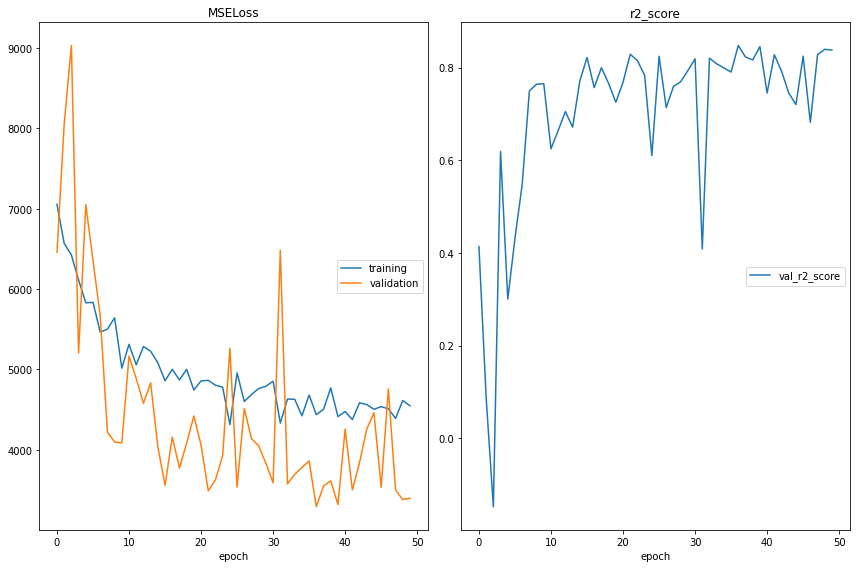

MSELoss
	training         	 (min: 4313.397, max: 7055.835, cur: 4547.748)
	validation       	 (min: 3290.697, max: 9032.719, cur: 3395.877)
r2_score
	val_r2_score     	 (min:   -0.148, max:    0.848, cur:    0.838)


In [8]:
## stage 0
## R2 score 0.81935

# Define Network
net = LinearModel(input_size=14, num_stage=0)

## Define Loss ~ Mean absolute  Error(MAE) Loss
loss = nn.MSELoss()

## Define Optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

train_model(dataloader, net, optimizer, criterion=loss, num_epochs=50, score=True)

In [9]:
net

LinearModel(
  (w1): Linear(in_features=14, out_features=256, bias=True)
  (batch_norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_stages): ModuleList()
  (w2): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU(inplace=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

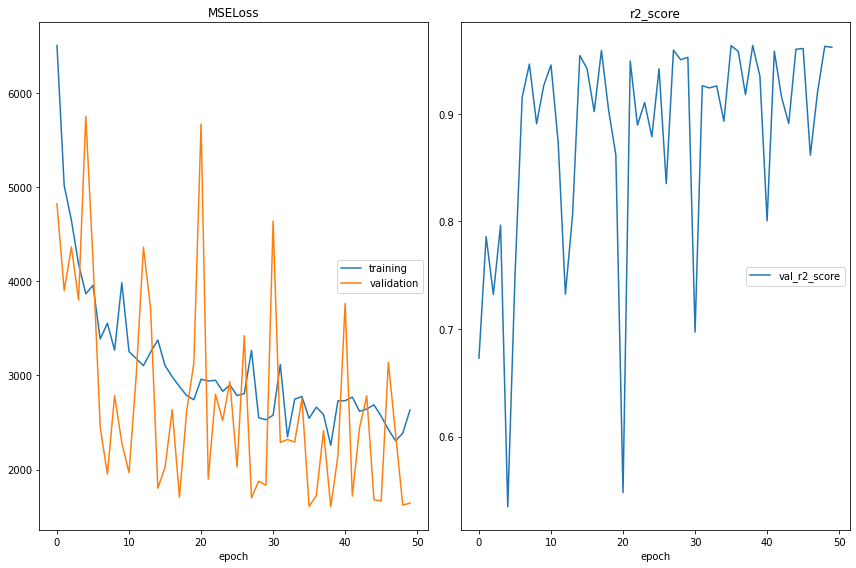

MSELoss
	training         	 (min: 2259.351, max: 6503.231, cur: 2633.585)
	validation       	 (min: 1606.493, max: 5751.167, cur: 1644.812)
r2_score
	val_r2_score     	 (min:    0.535, max:    0.964, cur:    0.962)


In [10]:
## stage 1
## R2 score

# Define Network
net = LinearModel(input_size=14, num_stage=1)

## Define Loss ~ Mean absolute  Error(MAE) Loss
loss = nn.MSELoss()

## Define Optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

train_model(dataloader, net, optimizer, criterion=loss, num_epochs=50, score=True)

In [11]:
net

LinearModel(
  (w1): Linear(in_features=14, out_features=256, bias=True)
  (batch_norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_stages): ModuleList(
    (0): Linear(
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (batch_norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (w2): Linear(in_features=256, out_features=256, bias=True)
      (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (w2): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU(inplace=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

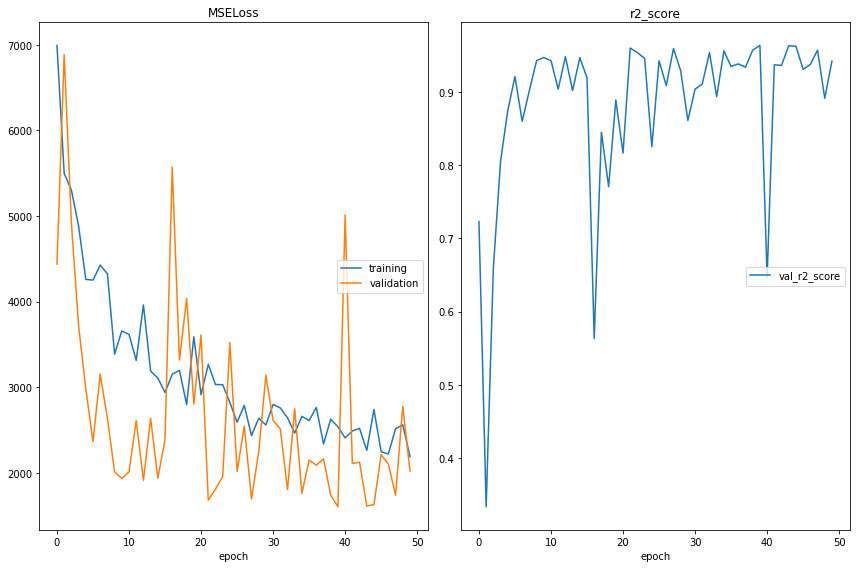

MSELoss
	training         	 (min: 2190.500, max: 6992.836, cur: 2190.500)
	validation       	 (min: 1604.137, max: 6884.857, cur: 2022.750)
r2_score
	val_r2_score     	 (min:    0.333, max:    0.964, cur:    0.942)


In [12]:
## stage 2
## R2 score 0.96509

# Define Network
net = LinearModel(input_size=14, num_stage=2)

## Define Loss ~ Mean absolute  Error(MAE) Loss
loss = nn.MSELoss()

## Define Optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

train_model(dataloader, net, optimizer, criterion=loss, num_epochs=50, score=True)

In [13]:
net

LinearModel(
  (w1): Linear(in_features=14, out_features=256, bias=True)
  (batch_norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_stages): ModuleList(
    (0): Linear(
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (batch_norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (w2): Linear(in_features=256, out_features=256, bias=True)
      (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Linear(
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (batch_norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (w2): Linear(in_features=256, out_features=256, bias=True)
      (batch_norm2): BatchNorm1d

In [14]:
'''
## 발산..

# Define Network
net = LinearModel(input_size=14, num_stage=8)

## Define Loss ~ Mean absolute  Error(MAE) Loss
loss = nn.MSELoss()

## Define Optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

train_model(dataloader, net, optimizer, criterion=loss, num_epochs=50, score=True)
'''

'\n## 발산..\n\n# Define Network\nnet = LinearModel(input_size=14, num_stage=8)\n\n## Define Loss ~ Mean absolute  Error(MAE) Loss\nloss = nn.MSELoss()\n\n## Define Optimizer\noptimizer = torch.optim.SGD(net.parameters(), lr=0.001)\n\ntrain_model(dataloader, net, optimizer, criterion=loss, num_epochs=50, score=True)\n'

In [15]:
# pred = test_model(dataloader['test'], net)
pred = test_model(dataloader['test'], net)

db['sample_submission']['predict'] = np.array(pred)
db['sample_submission'].to_csv('submit-kiy-w7p2-num3.csv', index=False)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
